In [1]:
# 1. Import packages
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2, os, datetime
import tensorflow as tf
import numpy as np

In [2]:
# 2. Data preparation
# 2.1 Prepare the path

train_path = r"C:\Users\artsc\Desktop\TensorFlow\Assessment4\dataset\train"
test_path = r"C:\Users\artsc\Desktop\TensorFlow\Assessment4\dataset\test"

In [3]:
# 2.2 Prepare empty list to hold the data
images = []
masks = []

# 2.3 Load the images using opencv
"""
os.listdir only gives us back the file name ya.
"""
train_input_dir = os.path.join(train_path, 'inputs')
for image_file in os.listdir(train_input_dir):
    img = cv2.imread(os.path.join(train_input_dir, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    images.append(img)

test_input_dir = os.path.join(test_path, 'inputs')
for image_file in os.listdir(test_input_dir):
    img = cv2.imread(os.path.join(test_input_dir, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    images.append(img)

# 2.4 Load the masks
train_mask_dir = os.path.join(train_path, 'masks')
for mask_file in os.listdir(train_mask_dir):
    mask = cv2.imread(os.path.join(train_mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    masks.append(mask)

test_mask_dir = os.path.join(test_path, 'masks')
for mask_file in os.listdir(test_mask_dir):
    mask = cv2.imread(os.path.join(test_mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    masks.append(mask)

In [4]:
# 2.5 Convert the list of np array into a np array

images_np = np.array(images)
masks_np = np.array(masks)

In [5]:
# 3. Data preprocessing
# 3.1 Expand the mask dimension

masks_np_exp = np.expand_dims(masks_np, axis=-1)

# Check the mask output, take a look at the binary value(black and white, 0 - 1)
print(np.unique(masks_np_exp[0]))

[  0  64 128 191 255]


In [6]:
# 3.2 Convert the mask values from [0, 255] into [0, 1] --> only work for binary mask
converted_masks = np.round(masks_np_exp / 255.0).astype(np.int64)

# Check the mask output
print(np.unique(converted_masks[0]))

[0 1]


In [7]:
# 3.3 Normalize the images
converted_images = images_np / 255.0

In [8]:
# 4. Perform train test split
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(converted_images, converted_masks, test_size=0.2, random_state=SEED)

In [9]:
# 5. Convert the numpy arrays into tensor slices
X_train_tensor = tf.data.Dataset.from_tensor_slices(X_train)
X_test_tensor = tf.data.Dataset.from_tensor_slices(X_test)
y_train_tensor = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tensor = tf.data.Dataset.from_tensor_slices(y_test)

In [10]:
# 6. Combine the images and masks using the zip method
"""
Forming a special type of data type which is zip datatype
"""
train_dataset = tf.data.Dataset.zip((X_train_tensor, y_train_tensor))
test_dataset = tf.data.Dataset.zip((X_test_tensor, y_test_tensor))

In [11]:
# 7. Define data augmentation pipeline as a single layer through subclassing

class Augment(keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = keras.layers.RandomFlip(mode='horizontal', seed=seed)
        self.augment_labels = keras.layers.RandomFlip(mode='horizontal', seed=seed)

    # apply augmentation on inputs and labels
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [12]:
# 8. Build the dataset --> train dataset
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
TRAIN_SIZE = len(train_dataset)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE

train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE) # always want to convert to prefetch dataset, so it faster. 
)

test_batches = test_dataset.batch(BATCH_SIZE)

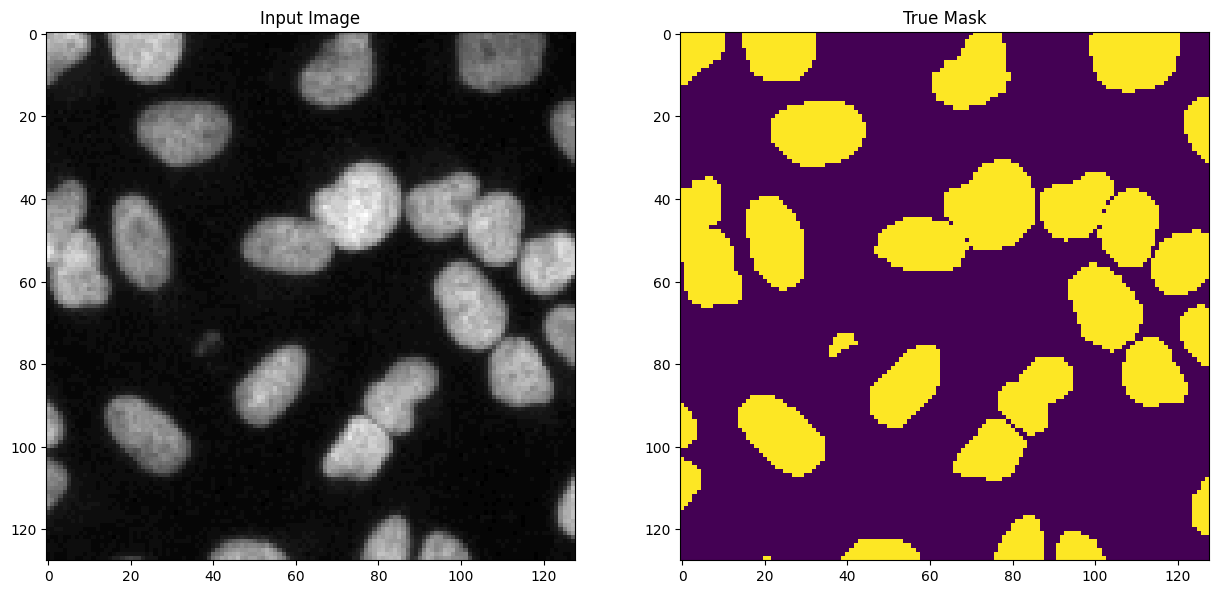

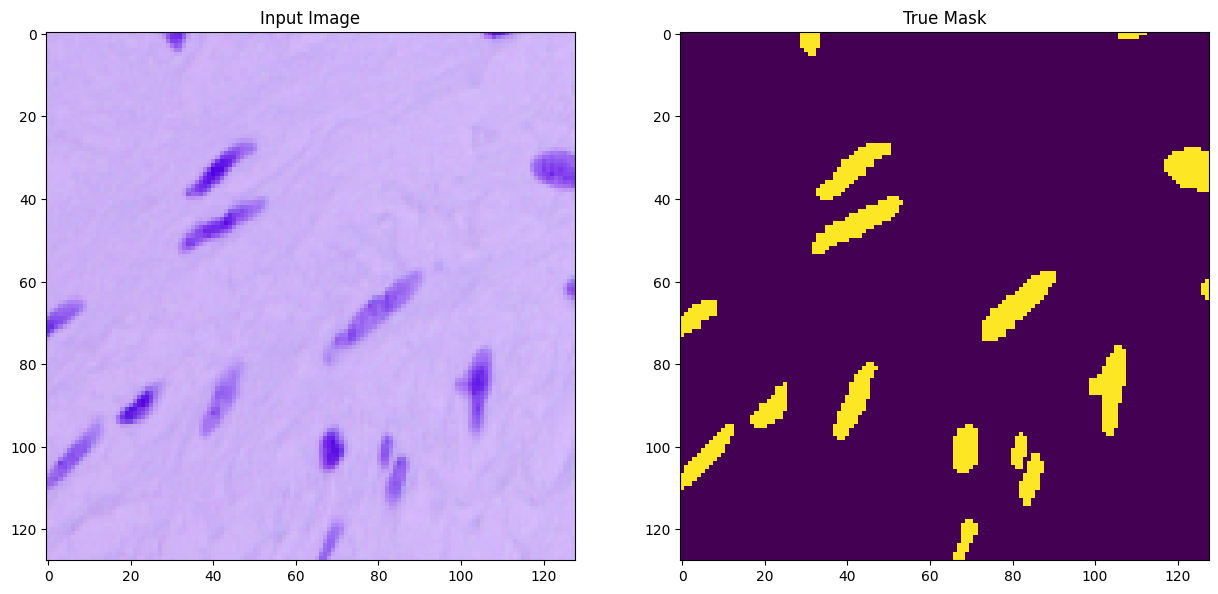

In [13]:
# 9. Visualize some pictures as example
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i])) # convert list into from array to image
    plt.show()

for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

In [14]:
# 10. Model development
# 10.1 Use a pretrained model as the feature extractor

base_model = keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

base_model.summary()
# 10.2 Use these activation layers as the outputs from the feature extractor (some of these outputs will be used to perform concatenation at the upsampling path)
layer_names = [
    'block_1_expand_relu',        #64x64
    'block_3_expand_relu',        #32x32
    'block_6_expand_relu',        #16x16
    'block_13_expand_relu',       #8x8
    'block_16_project'            #4x4    
    ]

# Define the output, includes all the layers as output
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]'

In [15]:
# 10.3 Reinstatiate the feature extractor

down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# we are not going to train this layer, apply transfer learning strategy no1.
down_stack.trainable = False

In [16]:
# 10.4 Define the upsampling path

up_stack = [
    pix2pix.upsample(512, 3),   #4x4 --> 8x8
    pix2pix.upsample(256, 3),   #8x8 --> 16x16
    pix2pix.upsample(128, 3),   #16x16 --> 32x32
    pix2pix.upsample(64, 3)     #32x32 --> 64x64
]

# 10.5 Use functional API to construct the entire U-net
def unet(output_channels:int):
    inputs = keras.layers.Input(shape=[128,128,3])
    
    skips = down_stack(inputs)
    x = skips[-1] # last output, for further propagation
    skips = reversed(skips[:-1])

    # Build the upsampling path and establish the concatenation
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = keras.layers.Concatenate()
        x = concat([x, skip]) # call the functional API

    # Use a transpose convolution layer to perform the last upsampling, this will become the output layer --> final output
    last = keras.layers.Conv2DTranspose(filters=output_channels, kernel_size=3, strides=2, padding='same') #64x64 --> 128x128
    outputs = last(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

In [17]:
# 10.6 Use the function to create the model
OUTPUT_CHANNELS = 3
model = unet(OUTPUT_CHANNELS)
model.summary()
keras.utils.plot_model(model)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                            

In [18]:
# 11. Compile the model

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

1/1 [==============================] - 2s 2s/step


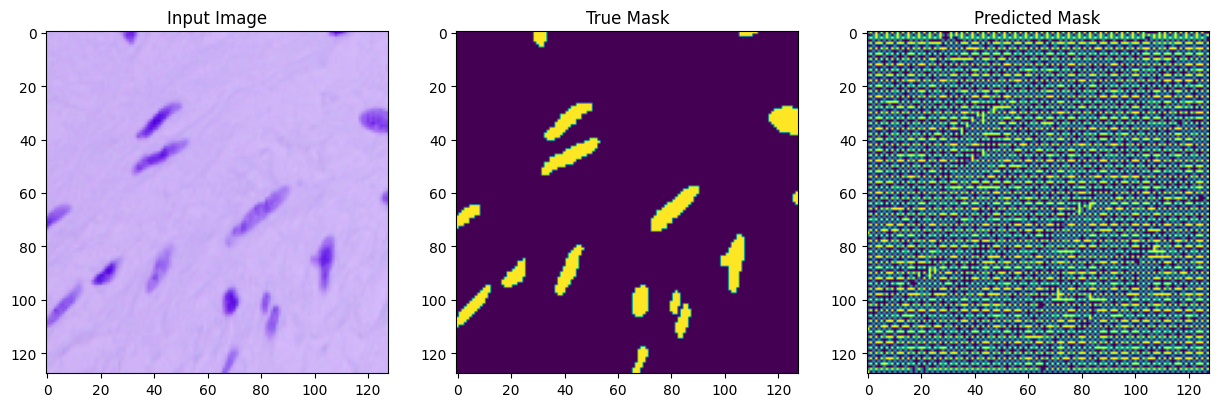

In [19]:
# 12. Create functions to show predictions

def create_mask(pred_mask):
    
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            # display 1 image, to display we can use the display function we define previously
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis,...]))])

show_predictions()

In [20]:
# 13. Create a callback function to make use of the show_predictions function

class DisplayCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample prediction after epoch{}\n'.format(epoch+1))

In [21]:
# 14. Setup TensorBoard callback
log_path = os.path.join('log_dir', 'Assessment_4', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = callbacks.TensorBoard(log_path)
es = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True, verbose=1)

1/1 [==============================] - 0s 74ms/step


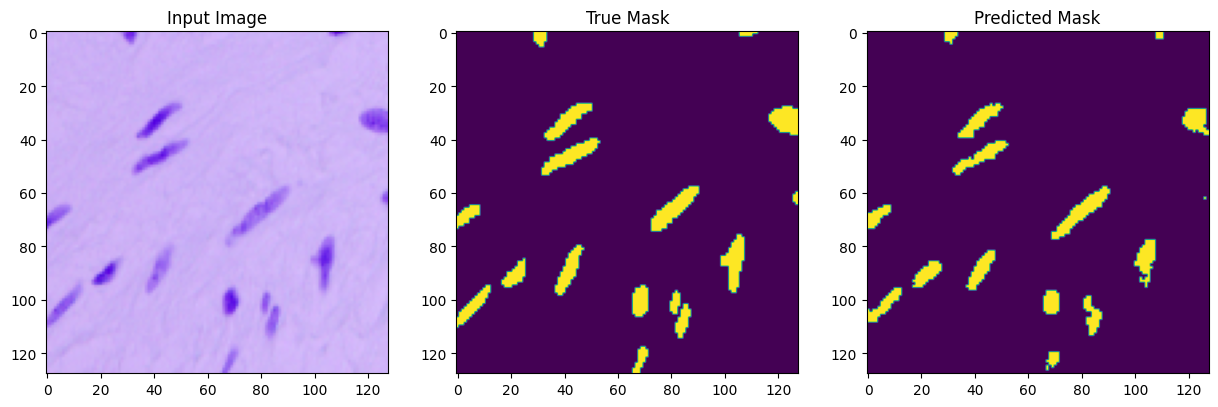


Sample prediction after epoch15

33/33 [==============================] - 37s 1s/step - loss: 0.0732 - accuracy: 0.9700 - val_loss: 0.0733 - val_accuracy: 0.9707


In [22]:
# 15. Model training

EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test_dataset) // BATCH_SIZE // VAL_SUBSPLITS 

history = model.fit(train_batches, 
validation_data=test_batches, validation_steps=VALIDATION_STEPS, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[DisplayCallback(), tb, es])

1/1 [==============================] - 2s 2s/step


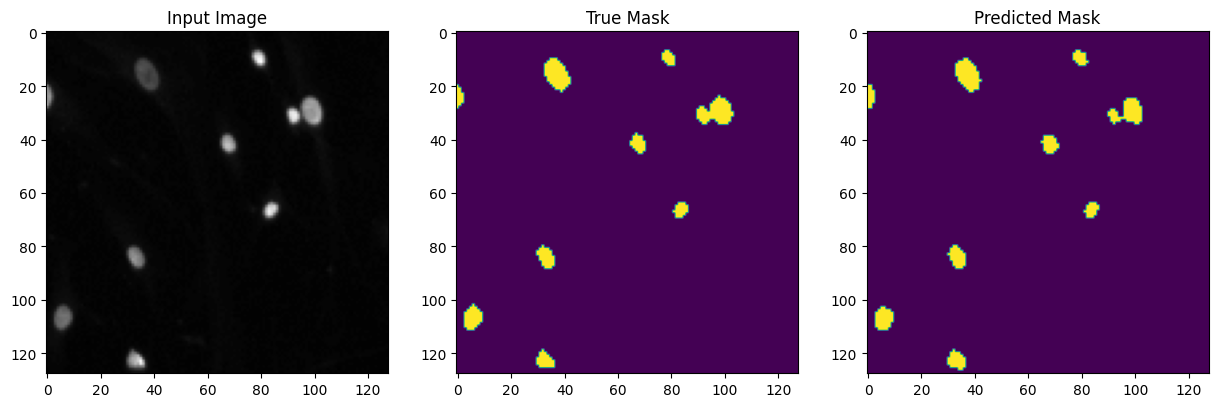

1/1 [==============================] - 1s 519ms/step


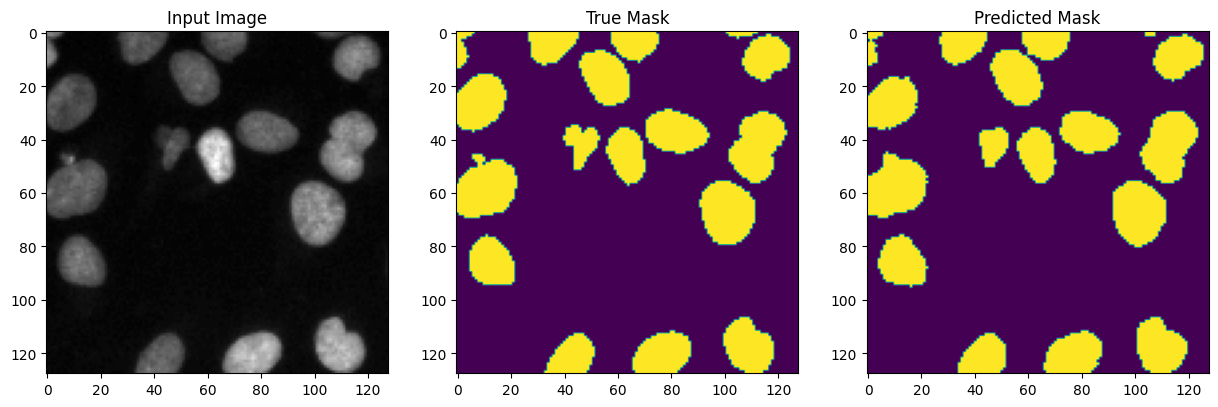

1/1 [==============================] - 1s 711ms/step


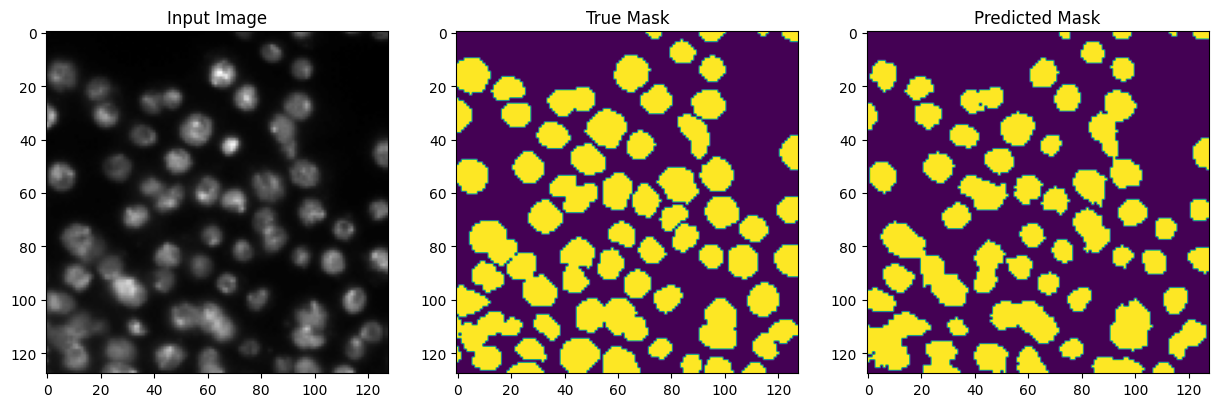

In [23]:
# 16. Model deployment

show_predictions(test_batches, 3)

In [24]:
# 17. Model save

model.save('model.h5')